# Project 3 - NLP
---

In [283]:
# Imports
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Data Cleaning
---

In [4]:
# Read in Books data
books_all = pd.read_csv('Data/books_combined.csv')

In [5]:
# Confirm enough rows are included
books_all.shape

(1311, 4)

In [6]:
books_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   created_utc  1311 non-null   float64
 1   title        1311 non-null   object 
 2   self_text    1037 non-null   object 
 3   subreddit    1311 non-null   object 
dtypes: float64(1), object(3)
memory usage: 41.1+ KB


In [7]:
# Reduce dataset to required 1k rows
books = books_all.head(1000)

In [8]:
books.shape

(1000, 4)

In [9]:
# Read in Movies data
movies_all = pd.read_csv('Data/movies_combined.csv')

In [10]:
movies_all.shape

(1709, 4)

In [11]:
# Reduce dataset to required 1k rows
movies = movies_all.head(1000)

In [12]:
movies.shape

(1000, 4)

In [13]:
# Combine each subreddit csv from PRAW into a combined csv to process
df = pd.concat([movies, books], ignore_index=True)

In [14]:
# Dataframe ready to go to work!
df.shape

(2000, 4)

In [192]:
#####

## Preprocessing + EDA
---

In [20]:
# Confirm column names
print(df.columns.tolist())

['created_utc', 'title', 'self_text', 'subreddit']


In [21]:
# Merge 'title' and 'self_text' into a single 'text' column
df['title'] = df['title'].fillna('')
df['self_text'] = df['self_text'].fillna('')
df['text'] = df['title'] + ' ' + df['self_text']

In [22]:
# Confirm new column was added
df.head()

,created_utc,title,self_text,subreddit,text
0,1.732202e+09,Sony Pictures Sues Wanda for $49 Million Over ...,,movies,Sony Pictures Sues Wanda for $49 Million Over ...
1,1.732201e+09,To save and project | Inside the final edition...,,movies,To save and project | Inside the final edition...
2,1.732201e+09,Man at War: Ridley Scott’s War Films Show an I...,,movies,Man at War: Ridley Scott’s War Films Show an I...
3,1.732200e+09,"Hi, /r/movies! I am Malcolm Washington, direct...",,movies,"Hi, /r/movies! I am Malcolm Washington, direct..."
4,1.732200e+09,Does anyone know where to find Laura Hasn't Sl...,"If you haven't heard of this movie, it's the s...",movies,Does anyone know where to find Laura Hasn't Sl...


In [23]:
df.shape

(2000, 5)

In [24]:
print(df.columns.tolist())

['created_utc', 'title', 'self_text', 'subreddit', 'text']


In [25]:
# Remove stop words

In [26]:
# download stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gfranksjr24/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
stop_words = set(stopwords.words('english'))

In [28]:
def remove_stopwords(text):
    if pd.isna(text):
        return ""
    words = str(text).split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [29]:
df['clean_text'] = df['text'].apply(remove_stopwords)

In [30]:
df.shape

(2000, 6)

In [31]:
df.head()

,created_utc,title,self_text,subreddit,text,clean_text
0,1.732202e+09,Sony Pictures Sues Wanda for $49 Million Over ...,,movies,Sony Pictures Sues Wanda for $49 Million Over ...,Sony Pictures Sues Wanda $49 Million Stymied ‘...
1,1.732201e+09,To save and project | Inside the final edition...,,movies,To save and project | Inside the final edition...,save project | Inside final edition Film Herit...
2,1.732201e+09,Man at War: Ridley Scott’s War Films Show an I...,,movies,Man at War: Ridley Scott’s War Films Show an I...,Man War: Ridley Scott’s War Films Show Inconsi...
3,1.732200e+09,"Hi, /r/movies! I am Malcolm Washington, direct...",,movies,"Hi, /r/movies! I am Malcolm Washington, direct...","Hi, /r/movies! Malcolm Washington, director co..."
4,1.732200e+09,Does anyone know where to find Laura Hasn't Sl...,"If you haven't heard of this movie, it's the s...",movies,Does anyone know where to find Laura Hasn't Sl...,anyone know find Laura Slept (2020 short)? hea...


In [32]:
# Remove special characters
df['clean_text'] = df['clean_text'].str.replace(r'[^\w\s]', '', regex=True)

In [33]:
df.head()

,created_utc,title,self_text,subreddit,text,clean_text
0,1.732202e+09,Sony Pictures Sues Wanda for $49 Million Over ...,,movies,Sony Pictures Sues Wanda for $49 Million Over ...,Sony Pictures Sues Wanda 49 Million Stymied Oc...
1,1.732201e+09,To save and project | Inside the final edition...,,movies,To save and project | Inside the final edition...,save project Inside final edition Film Herita...
2,1.732201e+09,Man at War: Ridley Scott’s War Films Show an I...,,movies,Man at War: Ridley Scott’s War Films Show an I...,Man War Ridley Scotts War Films Show Inconsist...
3,1.732200e+09,"Hi, /r/movies! I am Malcolm Washington, direct...",,movies,"Hi, /r/movies! I am Malcolm Washington, direct...",Hi rmovies Malcolm Washington director cowrite...
4,1.732200e+09,Does anyone know where to find Laura Hasn't Sl...,"If you haven't heard of this movie, it's the s...",movies,Does anyone know where to find Laura Hasn't Sl...,anyone know find Laura Slept 2020 short heard ...


In [34]:
print(df.columns.tolist()) 

['created_utc', 'title', 'self_text', 'subreddit', 'text', 'clean_text']


In [35]:
df = df.drop(['title', 'self_text', 'text'], axis=1)

In [36]:
print(df.columns.tolist()) 

['created_utc', 'subreddit', 'clean_text']


In [37]:
df.head()

,created_utc,subreddit,clean_text
0,1.732202e+09,movies,Sony Pictures Sues Wanda 49 Million Stymied Oc...
1,1.732201e+09,movies,save project Inside final edition Film Herita...
2,1.732201e+09,movies,Man War Ridley Scotts War Films Show Inconsist...
3,1.732200e+09,movies,Hi rmovies Malcolm Washington director cowrite...
4,1.732200e+09,movies,anyone know find Laura Slept 2020 short heard ...


In [38]:
# Change all characters to lowercase
df['clean_text'] = df['clean_text'].str.lower()

In [39]:
df.head()

,created_utc,subreddit,clean_text
0,1.732202e+09,movies,sony pictures sues wanda 49 million stymied oc...
1,1.732201e+09,movies,save project inside final edition film herita...
2,1.732201e+09,movies,man war ridley scotts war films show inconsist...
3,1.732200e+09,movies,hi rmovies malcolm washington director cowrite...
4,1.732200e+09,movies,anyone know find laura slept 2020 short heard ...


In [194]:
df.describe() # not useful unless column is converted to date fields

,created_utc
count,2.000000e+03
mean,1.730991e+09
std,1.289282e+06
min,1.727352e+09
25%,1.730290e+09
50%,1.731470e+09
75%,1.731948e+09
max,1.732376e+09


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   created_utc  2000 non-null   float64
 1   subreddit    2000 non-null   object 
 2   clean_text   2000 non-null   object 
dtypes: float64(1), object(2)
memory usage: 47.0+ KB


#### Count Vectorizing

In [149]:
# Instantiate a CountVectorizer object
cv = CountVectorizer()

# Fit and transform the count vectorizer on the clean_text column
cv_transformed = cv.fit_transform(df['clean_text'])

# Convert to a dense array
cv_dense = cv_transformed.toarray()

# Get the feature names (words)
feature_names = cv.get_feature_names_out()

# Create a DataFrame from the dense array
df_cv = pd.DataFrame(cv_dense, columns=feature_names)

# Add the subreddit column to the new DataFrame
df_cv['subreddit'] = df['subreddit'].values

In [151]:
df_cv.shape

(2000, 21120)

In [153]:
df_cv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 21120 entries, 000 to アナタハン
dtypes: int64(21119), object(1)
memory usage: 322.3+ MB


In [159]:
# Confirm subreddit column is still in dataframe
df_cv['subreddit'].head()

0    movies
1    movies
2    movies
3    movies
4    movies
Name: subreddit, dtype: object

In [163]:
# Sum up the occurrences of each word, excluding the subreddit column
word_freq = df_cv.drop(columns=['subreddit']).sum().sort_values(ascending=False)

# Get the top 25 most common words
top_25_words = word_freq.head(25)

print("25 most common words overall:")
print(top_25_words)

25 most common words overall:
book       2108
like       1772
movie      1324
one        1237
read       1088
im          988
books       975
think       899
would       872
it          836
really      786
reading     761
time        730
movies      724
even        716
people      702
also        677
know        623
much        611
story       604
film        592
get         579
first       566
good        553
ive         543
dtype: int64


In [167]:
# Filter for the 'movies' subreddit
movies_df_cv = df_cv[df_cv['subreddit'] == 'movies']

# Sum up the occurrences of each word, excluding the subreddit column
movies_word_freq = movies_df_cv.drop(columns=['subreddit']).sum().sort_values(ascending=False)

# Get the top 25 most common words for movies
top_25_movies_words = movies_word_freq.head(25)

print("25 most common words in movies subreddit:")
print(top_25_movies_words)

25 most common words in movies subreddit:
movie     1271
like       714
movies     690
film       558
one        545
im         407
would      403
think      391
day        364
even       337
time       330
really     308
it         286
films      277
also       272
see        270
get        265
know       261
good       253
watch      253
people     245
much       231
first      222
ive        220
best       211
dtype: int64


In [169]:
# Filter for the 'books' subreddit
books_df_cv = df_cv[df_cv['subreddit'] == 'books']

# Sum up the occurrences of each word, excluding the subreddit column
books_word_freq = books_df_cv.drop(columns=['subreddit']).sum().sort_values(ascending=False)

# Get the top 25 most common words for books
top_25_books_words = books_word_freq.head(25)

print("25 most common words in books subreddit:")
print(top_25_books_words)

25 most common words in books subreddit:
book          2065
like          1058
read          1037
books          965
reading        746
one            692
im             581
it             550
think          508
really         478
would          469
people         457
story          431
also           405
time           400
much           380
even           379
characters     363
know           362
the            351
feel           348
life           348
way            347
first          344
ive            323
dtype: int64


In [171]:
# Sum up occurrences of each word by subreddit
#movies_word_freq = df_cv[df_cv['subreddit'] == 'movies'].drop(columns='subreddit').sum().sort_values(ascending=False)
#books_word_freq = df_cv[df_cv['subreddit'] == 'books'].drop(columns='subreddit').sum().sort_values(ascending=False)

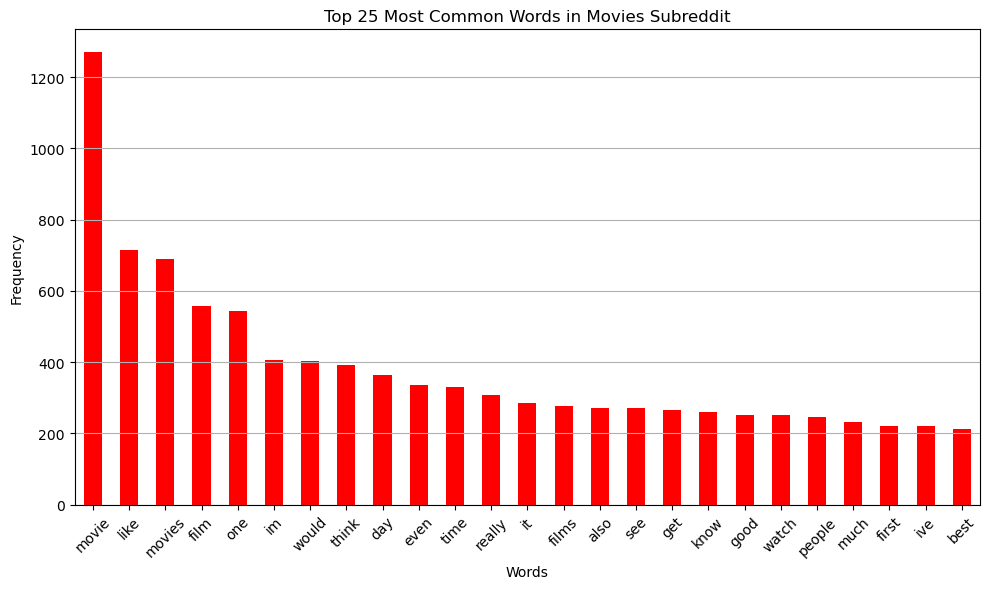

In [291]:
# Take out the top 25 movies dataframe words 
top_25_movies_words = movies_word_freq.head(25)

# Create a bar chart
plt.figure(figsize=(10, 6))
top_25_movies_words.plot(kind='bar', color='red')

# Set the title and labels
plt.title('Top 25 Most Common Words in Movies Subreddit')
plt.xlabel('Words')
plt.ylabel('Frequency')

# Rotate x-axis labels 
plt.xticks(rotation=45)

# Show grid
plt.grid(axis='y')

# Display the chart
plt.tight_layout() 
plt.show()

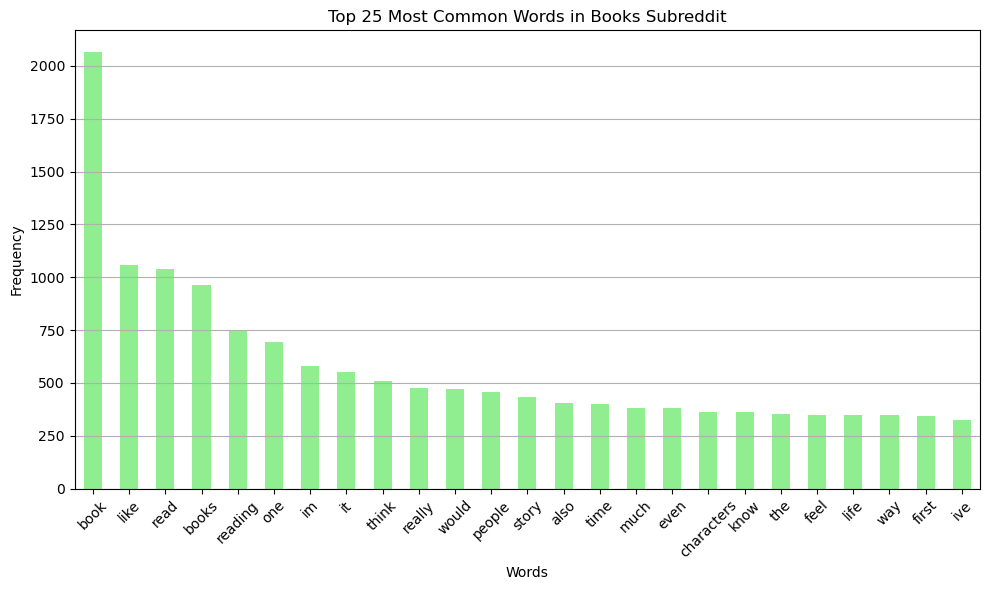

In [289]:
# Take out the top 25 books dataframe words 
top_25_books_words = books_word_freq.head(25)

# Create a bar chart
plt.figure(figsize=(10, 6))
top_25_books_words.plot(kind='bar', color='lightgreen')

# Set the title and labels
plt.title('Top 25 Most Common Words in Books Subreddit')
plt.xlabel('Words')
plt.ylabel('Frequency')

# Rotate x-axis labels 
plt.xticks(rotation=45)

# Show grid
plt.grid(axis='y')

# Display the chart
plt.tight_layout() 
plt.show()

In [189]:
########

### Sentiment Analysis

In [203]:
books_word_freq.head()

book       2065
like       1058
read       1037
books       965
reading     746
dtype: int64

In [205]:
movies_word_freq.head()

movie     1271
like       714
movies     690
film       558
one        545
dtype: int64

In [209]:
# Initialize the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

def analyze_sentiment(word):
    # Get sentiment scores for the word
    scores = sid.polarity_scores(word)
    return scores['compound'], scores['pos'], scores['neg'], scores['neu']

In [211]:
# Analyzing sentiment for books
books_sentiment = books_word_freq.index.to_series().apply(analyze_sentiment)
books_sentiment_df = pd.DataFrame(books_sentiment.tolist(), index=books_word_freq.index, columns=['compound', 'positive', 'negative', 'neutral'])

# Analyzing sentiment for movies
movies_sentiment = movies_word_freq.index.to_series().apply(analyze_sentiment)
movies_sentiment_df = pd.DataFrame(movies_sentiment.tolist(), index=movies_word_freq.index, columns=['compound', 'positive', 'negative', 'neutral'])

# Display results
print("Books Sentiment Scores:")
print(books_sentiment_df)

print("\nMovies Sentiment Scores:")
print(movies_sentiment_df)

Books Sentiment Scores:
              compound  positive  negative  neutral
book            0.0000       0.0       0.0      1.0
like            0.3612       1.0       0.0      0.0
read            0.0000       0.0       0.0      1.0
books           0.0000       0.0       0.0      1.0
reading         0.0000       0.0       0.0      1.0
...                ...       ...       ...      ...
irredeemable    0.0000       0.0       0.0      1.0
irresistible    0.3400       1.0       0.0      0.0
irritated      -0.4588       0.0       1.0      0.0
isaacs          0.0000       0.0       0.0      1.0
アナタハン           0.0000       0.0       0.0      1.0

[21119 rows x 4 columns]

Movies Sentiment Scores:
                                                    compound  positive  \
movie                                                 0.0000       0.0   
like                                                  0.3612       1.0   
movies                                                0.0000       0.0   
film

In [217]:
# Get top positive and negative words for books
top_books_positive = books_sentiment_df.nlargest(15, 'compound')
top_books_negative = books_sentiment_df.nsmallest(15, 'compound')

# Get top positive and negative words for movies
top_movies_positive = movies_sentiment_df.nlargest(15, 'compound')
top_movies_negative = movies_sentiment_df.nsmallest(15, 'compound')

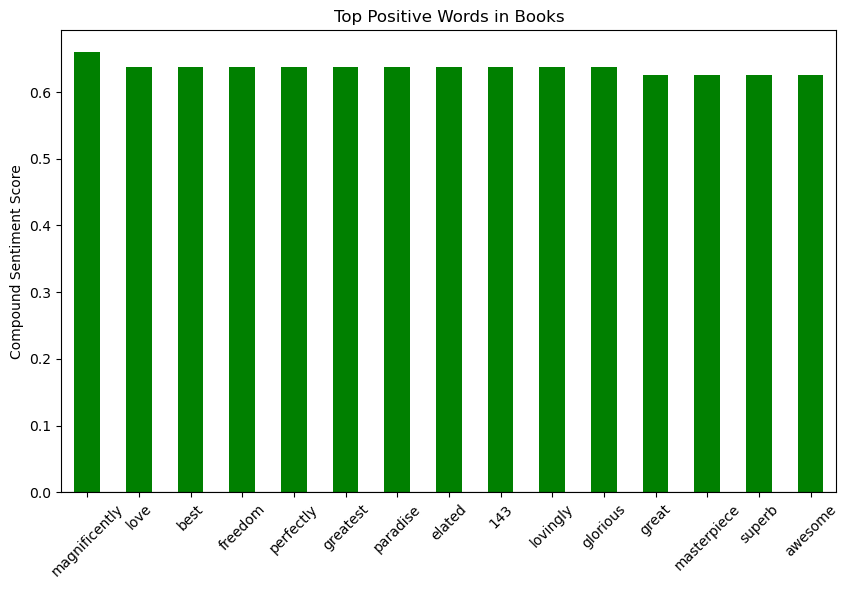

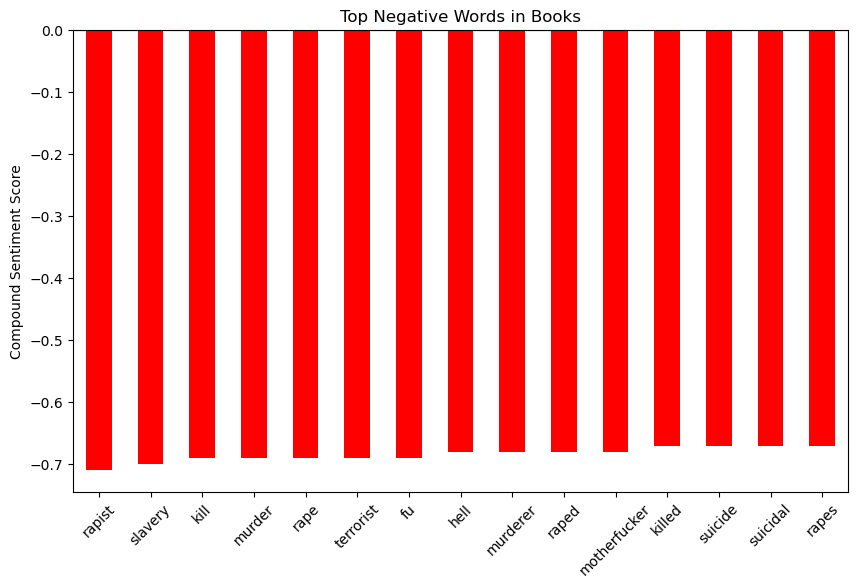

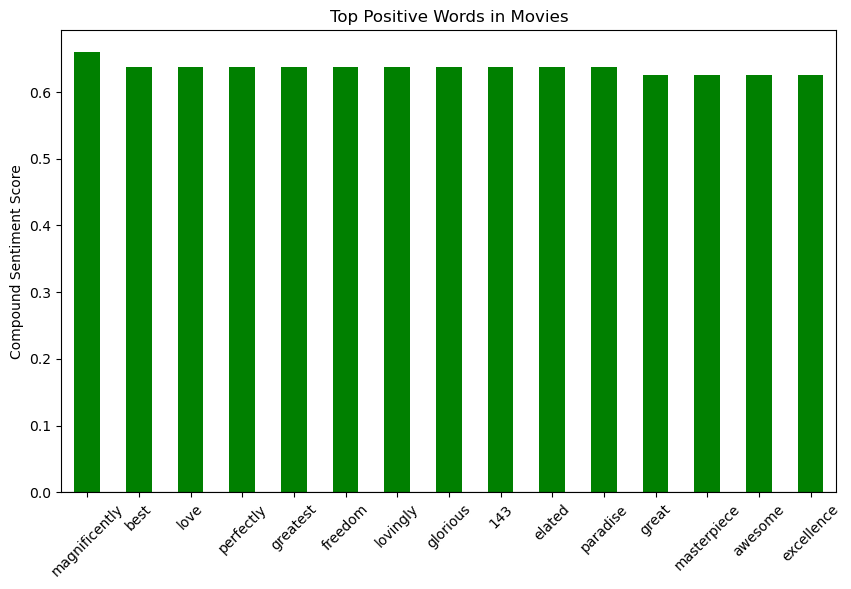

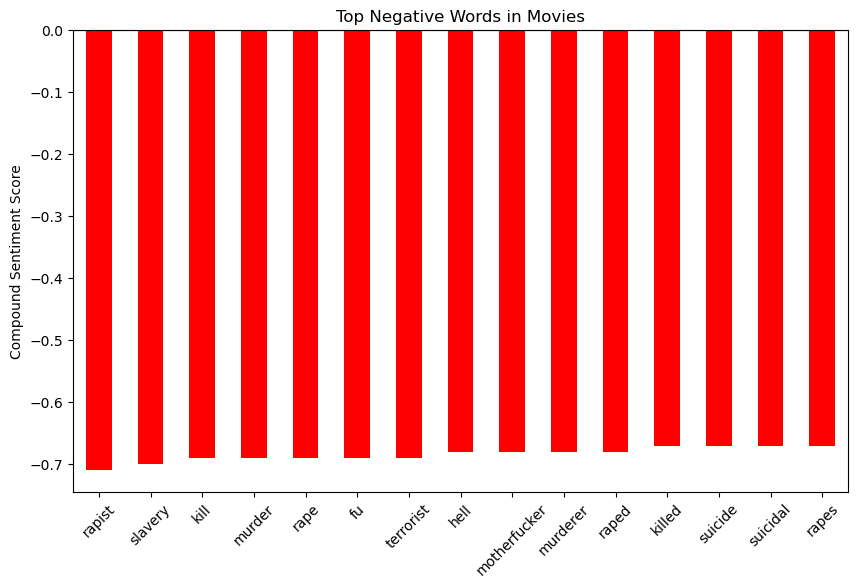

In [219]:
# Create a function to plot bar charts
def plot_sentiment_barchart(dataframe, title):
    plt.figure(figsize=(10, 6))
    dataframe['compound'].plot(kind='bar', color=['green' if x >= 0 else 'red' for x in dataframe['compound']])
    plt.title(title)
    plt.ylabel('Compound Sentiment Score')
    plt.xticks(rotation=45)
    plt.axhline(0, color='black', linewidth=0.8)
    plt.show()

# Plotting charts for books
plot_sentiment_barchart(top_books_positive, "Top Positive Words in Books")
plot_sentiment_barchart(top_books_negative, "Top Negative Words in Books")

# Plotting charts for movies
plot_sentiment_barchart(top_movies_positive, "Top Positive Words in Movies")
plot_sentiment_barchart(top_movies_negative, "Top Negative Words in Movies")

In [225]:
#(Remove common words that exist in both datasets)

## Modeling + Comparison
---

In [41]:
# Create X and y variables
X = df['clean_text']
y = df['subreddit']

In [42]:
# Train_Test_Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Logistic Regression Pipeline with TfidfVectorizer
lr_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression())
])

lr_pipeline.fit(X_train, y_train)
lr_predictions = lr_pipeline.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)

In [44]:
# Random Forest Pipeline with TfidfVectorizer
rf_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', RandomForestClassifier())
])

rf_pipeline.fit(X_train, y_train)
rf_predictions = rf_pipeline.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)

In [45]:
# Print out accuracy scores for each model
print(f"Logistic Regression Accuracy: {lr_accuracy}")
print(f"Random Forest Accuracy: {rf_accuracy}")

Logistic Regression Accuracy: 0.9825
Random Forest Accuracy: 0.9675


In [46]:
# Baseline accuracy
y_test.value_counts(normalize=True)

subreddit
books     0.5025
movies    0.4975
Name: proportion, dtype: float64

In [47]:
# Baseline accuracy is the highest value above.

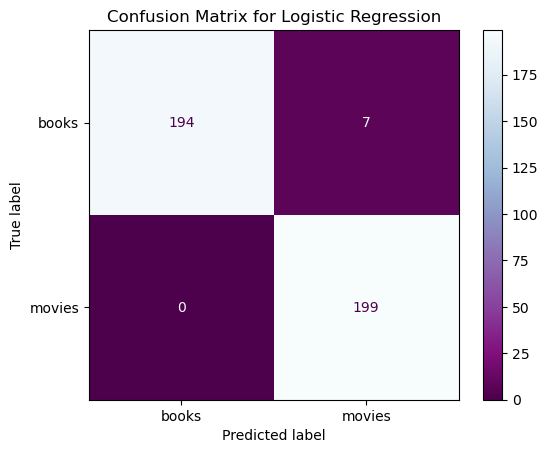

In [234]:
# Create the confusion matrix
cm_lr = confusion_matrix(y_test, lr_predictions)

# Create a ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=lr_pipeline.classes_)

# Plot the confusion matrix
cm_display.plot(cmap=plt.cm.BuPu_r)
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [255]:
# Extract values from the confusion matrix for Logistic Regression
tn, fp, fn, tp = cm_lr.ravel()

print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

True Negatives: 194
False Positives: 7
False Negatives: 0
True Positives: 199


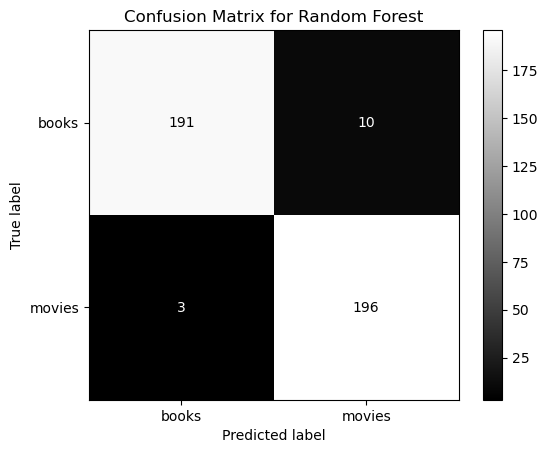

In [246]:
# Create the confusion matrix
cm_rf = confusion_matrix(y_test, rf_predictions)

# Create and plot the confusion matrix plot
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_pipeline.classes_)
cm_display.plot(cmap=plt.cm.gist_gray)
plt.title('Confusion Matrix for Random Forest')
plt.show()

In [257]:
# Extract values from the confusion matrix for Random Forest
tn, fp, fn, tp = cm_rf.ravel()

print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

True Negatives: 191
False Positives: 10
False Negatives: 3
True Positives: 196


In [280]:
#Compare Model Scores

In [264]:
def calculate_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print()

# Calculate metrics for Logistic Regression
calculate_metrics(y_test, lr_predictions, "Logistic Regression")

# Calculate metrics for Random Forest
calculate_metrics(y_test, rf_predictions, "Random Forest")

Logistic Regression Metrics:
Accuracy: 0.9825
Precision: 0.9831
Recall: 0.9825
F1 Score: 0.9825

Random Forest Metrics:
Accuracy: 0.9675
Precision: 0.9681
Recall: 0.9675
F1 Score: 0.9675

